In [1]:
import gpflow
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
import pandas as pd
from sklearn.preprocessing import StandardScaler

set_default_float(np.float64)
set_default_summary_fmt("notebook")

In [2]:
gene_data = pd.read_csv("guo_qpcr.csv", index_col=0)

In [3]:
gene_data

,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64 TE,-0.981846,0.652971,-0.376022,-1.414495,0.372440,-0.978892,-0.636869,-0.856056,-0.767485,-1.365015,...,1.112031,0.618734,-0.344299,0.952105,-0.272503,-1.453339,0.299896,0.844418,1.251070,-1.276398
64 TE,-1.298196,0.980800,-0.767402,-1.408511,0.551521,-0.644643,0.926355,-0.478230,-0.739008,-1.428797,...,0.385848,1.068621,1.203923,1.057349,-0.064275,-1.068977,0.966150,0.988691,1.394258,-1.154409
64 TE,-0.716994,0.787200,0.020074,1.226372,0.638402,-0.806083,1.003183,-1.200070,-0.506173,-1.331172,...,0.185657,0.686556,0.175714,1.108408,-0.262818,-0.877706,0.270610,1.058685,1.463726,-1.170975
64 TE,-1.003917,1.522880,-0.289572,-1.532177,0.246551,-0.603714,0.656671,0.877241,-0.940018,-1.345490,...,0.911840,1.226873,1.071556,0.878122,-0.038448,-1.324004,0.731863,0.742998,1.150413,-1.160433


In [4]:
print(gene_data.index.unique())

Index(['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE',
       '64 EPI'],
      dtype='object')


In [44]:
time_map = {'1': 1, '2': 2, '4': 4, '8': 8, '16': 16, '32 ICM': 32, '32 TE': 32, '64 PE': 64, '64 TE': 64, '64 EPI': 64}

gene_data['Time'] = gene_data.index.map(time_map)

In [45]:
gene_data.sort_values(by=['Time'], inplace=True)

In [46]:
print(gene_data.index)

Index(['1', '1', '1', '1', '1', '1', '1', '1', '1', '2',
       ...
       '64 PE', '64 PE', '64 EPI', '64 PE', '64 TE', '64 TE', '64 PE',
       '64 EPI', '64 PE', '64 TE'],
      dtype='object', length=437)


In [47]:
time = gene_data['Time'].values / 6

In [48]:
gene_data = gene_data.drop(['Time'], axis=1)

In [49]:
# scaler = StandardScaler()
# Y = scaler.fit_transform(gene_data.values)
Y = gene_data.values
Y = tf.convert_to_tensor(Y, dtype=default_float())

raw_labels = np.array(gene_data.index)
labels = tf.convert_to_tensor(raw_labels)


In [50]:
labels

<tf.Tensor: shape=(437,), dtype=string, numpy=
array([b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'2', b'2',
       b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2',
       b'2', b'2', b'2', b'2', b'2', b'2', b'4', b'4', b'4', b'4', b'4',
       b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4',
       b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'8', b'8', b'8', b'8',
       b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8',
       b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8',
       b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8',
       b'8', b'8', b'8', b'8', b'8', b'8', b'16', b'16', b'16', b'16',
       b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16',
       b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16',
       b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16',
       b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16',
       b'16', b'16

In [51]:
print("Number of points: {} and Number of dimensions: {}".format(Y.shape[0], Y.shape[1]))


Number of points: 437 and Number of dimensions: 48


In [52]:
latent_dim = 2 # number of latent dimensions
num_inducing = 200  # number of inducing pts
num_data = Y.shape[0]  # number of data points

In [53]:
X_mean_init = ops.pca_reduce(Y, latent_dim)
X_var_init = tf.ones((num_data, latent_dim), dtype=default_float())

In [54]:
# capture_time = tf.convert_to_tensor([int(cell_name.split(" ")[0]) for cell_name in gene_data.index.values], dtype=default_float())
# # we scale the time into the interval [0, 1]
# time = np.log2(capture_time) / 6

In [55]:
X_mean_init

<tf.Tensor: shape=(437, 2), dtype=float64, numpy=
array([[-7.87687773e-01,  1.10257781e+00],
       [-1.72467462e+00,  1.11367399e+00],
       [-2.36323726e+00,  2.76249935e-01],
       [-2.51741219e+00,  7.73030378e-01],
       [-1.77895593e+00,  5.14028338e-01],
       [-2.41042590e+00,  1.91070740e-01],
       [-2.63403109e+00,  4.43880826e-01],
       [-2.10701980e+00,  3.59724200e-01],
       [-2.99733183e+00,  7.32623762e-01],
       [-1.65076735e+00,  2.21928498e+00],
       [-3.11936652e-02,  2.68565477e+00],
       [-6.98003090e-01,  2.09114035e+00],
       [-3.79954426e-01,  3.20381430e+00],
       [ 1.89484048e-01,  2.16283012e+00],
       [ 3.60083283e-02,  3.02841532e+00],
       [-9.66269985e-01,  2.09850968e+00],
       [-1.87655546e-01,  2.74829735e+00],
       [-8.73004045e-01,  2.49745160e+00],
       [-5.55630257e-01,  2.38825592e+00],
       [-2.85329043e+00,  2.06291758e+00],
       [ 3.36357603e-01,  3.44486621e+00],
       [-1.50156280e+00,  3.35486398e+00],
    

In [56]:
X_mean_init = X_mean_init.numpy()
X_mean_init[:, 0] = time
X_mean_init = tf.convert_to_tensor(X_mean_init, dtype=default_float())

In [57]:
np.random.seed(1)  # for reproducibility
inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
)

In [58]:
lengthscales = tf.convert_to_tensor([1] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)

gplvm = gpflow.models.GPLVM(
    Y,
    X_data_mean=X_mean_init,
    latent_dim=latent_dim,
    kernel=kernel,
)

gplvm.likelihood.variance.assign(0.1)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-2.2521789694259944>

In [59]:
opt = gpflow.optimizers.Scipy()

lml = []

def step_callback(step, variables, values):
        lml.append(gplvm.log_marginal_likelihood().numpy())
        print('step: ',step, 'lml: ', gplvm.log_marginal_likelihood().numpy())

maxiter = 2000
_ = opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
    step_callback=step_callback
)

step:  0 lml:  -21430.49607703182
step:  1 lml:  -20912.727731790146
step:  2 lml:  -20073.76798998867
step:  3 lml:  -19751.867451330043
step:  4 lml:  -19559.811194284972
step:  5 lml:  -19265.061306918426
step:  6 lml:  -19190.18074704057
step:  7 lml:  -19070.712898435628
step:  8 lml:  -18932.344675195458
step:  9 lml:  -18858.438489682285
step:  10 lml:  -18784.387260277643
step:  11 lml:  -18715.357195875924
step:  12 lml:  -18648.472346492526
step:  13 lml:  -18585.663191886066
step:  14 lml:  -18555.136301771192
step:  15 lml:  -18520.866084943274
step:  16 lml:  -18480.74086113622
step:  17 lml:  -18467.961096362204
step:  18 lml:  -18448.412566508967
step:  19 lml:  -18421.694138773382
step:  20 lml:  -18394.01578275965
step:  21 lml:  -18361.116865162978
step:  22 lml:  -18334.92061164885
step:  23 lml:  -18305.631426671185
step:  24 lml:  -18275.569078958295
step:  25 lml:  -18244.554322964195
step:  26 lml:  -18220.974972318807
step:  27 lml:  -18195.25963976975
step:  28

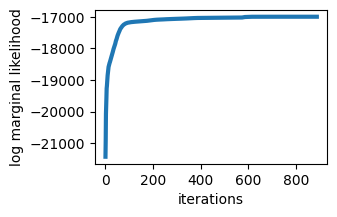

In [67]:
fig = plt.figure(figsize=(3,2))  
plt.plot(range(len(lml)), lml, linewidth=3)
plt.xlabel('iterations')
plt.ylabel('log marginal likelihood')
plt.savefig('lml.png', bbox_inches='tight', dpi=500)
plt.show()

In [22]:
gplvm.data[0]

<Parameter: name=identity, dtype=float64, shape=[437, 2], fn="identity", numpy=
array([[-2.90543993e+00,  2.16658822e+00],
       [-2.98998327e+00,  2.66257832e+00],
       [-2.96646633e+00,  2.56469654e+00],
       [-2.96549108e+00,  2.73794379e+00],
       [-2.95545189e+00,  3.17247767e+00],
       [-3.10001534e+00,  2.52643536e+00],
       [-2.99679369e+00,  2.24992880e+00],
       [-2.96816723e+00,  2.70491233e+00],
       [-2.89196343e+00,  2.80017694e+00],
       [-2.15282753e+00,  1.93563472e+00],
       [-1.12142516e+00,  3.00963880e+00],
       [-1.06192563e+00,  3.12392643e+00],
       [-1.18366185e+00,  1.59074494e+00],
       [-1.31969773e+00,  9.63185178e-01],
       [-1.25744809e+00,  3.61909530e+00],
       [-1.11163436e+00,  4.06550467e+00],
       [-1.80995610e+00,  3.95331313e+00],
       [-1.05719481e+00,  1.53158776e+00],
       [-1.40135630e+00,  1.15794217e+00],
       [-1.36391432e+00,  2.70141290e+00],
       [-2.01196355e+00,  1.76305776e+00],
       [-1.369881

In [23]:
labels

<tf.Tensor: shape=(437,), dtype=string, numpy=
array([b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'2', b'2',
       b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2', b'2',
       b'2', b'2', b'2', b'2', b'2', b'2', b'4', b'4', b'4', b'4', b'4',
       b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'4',
       b'4', b'4', b'4', b'4', b'4', b'4', b'4', b'8', b'8', b'8', b'8',
       b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8',
       b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8',
       b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8', b'8',
       b'8', b'8', b'8', b'8', b'8', b'8', b'16', b'16', b'16', b'16',
       b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16',
       b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16',
       b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16',
       b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16', b'16',
       b'16', b'16

step:  0 lml:  -32330.580573150422
step:  1 lml:  -28083.958919183086
step:  2 lml:  -24695.163127465326
step:  3 lml:  -23634.293353361136
step:  4 lml:  -23324.576707083517
step:  5 lml:  -23152.51772383581
step:  6 lml:  -22891.574148197033
step:  7 lml:  -22814.36621264113
step:  8 lml:  -22806.90036311152
step:  9 lml:  -22804.015039499045
step:  10 lml:  -22800.36793094905
step:  11 lml:  -22798.295675422974
step:  12 lml:  -22796.184664466
step:  13 lml:  -22794.758525583326
step:  14 lml:  -22792.391646294214
step:  15 lml:  -22788.111120511072
step:  16 lml:  -22767.839397808595
step:  17 lml:  -22765.46619331825
step:  18 lml:  -22762.38007487132
step:  19 lml:  -22760.97304298712
step:  20 lml:  -22759.378732239755
step:  21 lml:  -22756.45418300421
step:  22 lml:  -22751.768967029417
step:  23 lml:  -22749.370411699703
step:  24 lml:  -22744.80586720544
step:  25 lml:  -22738.39809418693
step:  26 lml:  -22737.14761240605
step:  27 lml:  -22726.919603808103
step:  28 lml:  

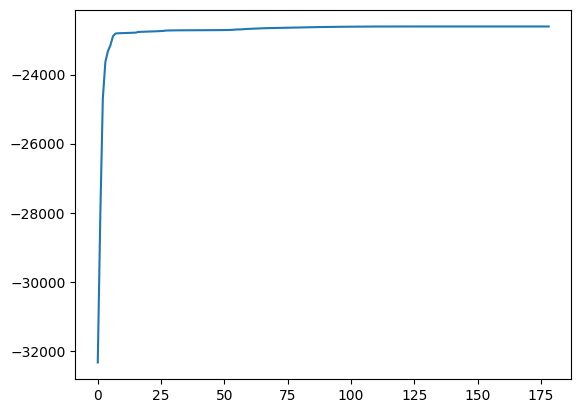

In [24]:
# PPCA

kernel = gpflow.kernels.Linear(variance=1)

ppca = gpflow.models.GPLVM(
    Y,
    X_data_mean=X_mean_init,
    latent_dim=latent_dim,
    kernel=kernel,
)
gpflow.utilities.set_trainable(ppca.kernel.variance, False)

ppca.likelihood.variance.assign(0.1)

opt = gpflow.optimizers.Scipy()

lml = []

def step_callback(step, variables, values):
        lml.append(ppca.log_marginal_likelihood().numpy())
        print('step: ',step, 'lml: ', ppca.log_marginal_likelihood().numpy())

maxiter = 1000
_ = opt.minimize(
    ppca.training_loss,
    method="BFGS",
    variables=ppca.trainable_variables,
    options=dict(maxiter=maxiter),
    step_callback=step_callback
)

plt.plot(range(len(lml)), lml)

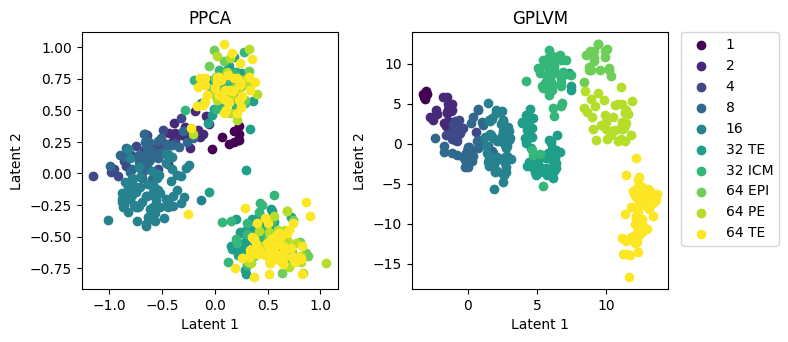

In [63]:
gplvm_X_mean = gplvm.data[0].numpy()
ppca_X_mean = ppca.data[0].numpy()
f, ax = plt.subplots(1, 2, figsize=(8,4))
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
# colors = [mpl.colors.to_hex(plt.cm.viridis(i)) for i in np.linspace(0, 1, len(np.unique(labels)))]
unique_labels, idx = np.unique(labels, return_index=True)
unique_labels = labels.numpy()[np.sort(idx)]

for n, i in enumerate(unique_labels):
    ax[0].scatter(ppca_X_mean[labels == i, 0], ppca_X_mean[labels == i, 1], label=i, color=colors[n])
    ax[1].scatter(gplvm_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    ax[0].set_title("PPCA")
    ax[1].set_title("GPLVM")

for ax_ in ax:
    ax_.set_box_aspect(1)   
    ax_.set_xlabel("Latent 1")
    ax_.set_ylabel("Latent 2")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig('PPCA_GPLVM_cell_data.png', dpi=500, bbox_inches='tight')

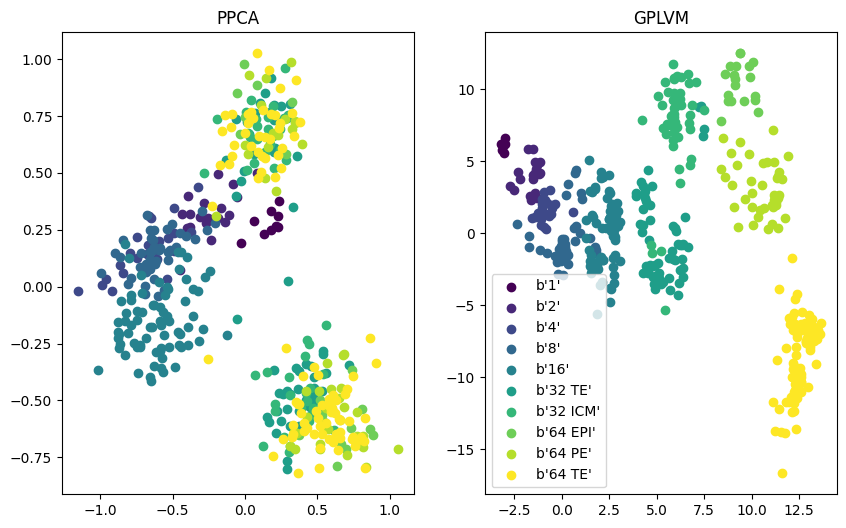

In [61]:
import matplotlib as mpl
_pca = ops.pca_reduce(Y, latent_dim).numpy()
gplvm_X_mean = gplvm.data[0].numpy()
f, ax = plt.subplots(1, 2, figsize=(10, 6))
ppca_X_mean = ppca.data[0].numpy()
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
# colors = [mpl.colors.to_hex(plt.cm.viridis(i)) for i in np.linspace(0, 1, len(np.unique(labels)))]
unique_labels, idx = np.unique(labels, return_index=True)
unique_labels = labels.numpy()[np.sort(idx)]

for n, i in enumerate(unique_labels):
    ax[0].scatter(ppca_X_mean[labels == i, 0], ppca_X_mean[labels == i, 1], label=i, color=colors[n])
    ax[1].scatter(gplvm_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=i, color=colors[n])
    ax[0].set_title("PPCA")
    ax[1].set_title("GPLVM")
ax[1].legend()

<BarContainer object of 2 artists>

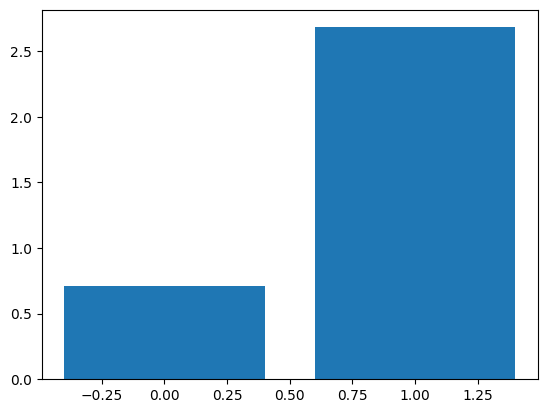

In [26]:
plt.bar(np.arange(latent_dim), gplvm.kernel.lengthscales.numpy())

In [ ]:
# latent_dim = 2
# X_mean_init = ops.pca_reduce(Y, latent_dim)
# X_var_init = tf.ones((num_data, latent_dim), dtype=default_float())


In [27]:

inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
)

lengthscales = tf.convert_to_tensor([1] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.RBF(lengthscales=lengthscales)

bgplvm = gpflow.models.BayesianGPLVM(
    Y,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    kernel=kernel,
    inducing_variable=inducing_variable,
)

bgplvm.likelihood.variance.assign(0.1)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-2.2521789694259944>

In [28]:
X_mean_init

<tf.Tensor: shape=(437, 2), dtype=float64, numpy=
array([[ 0.16666667,  1.10257781],
       [ 0.16666667,  0.3597242 ],
       [ 0.16666667,  0.44388083],
       [ 0.16666667,  0.19107074],
       [ 0.16666667,  0.73262376],
       [ 0.16666667,  0.77303038],
       [ 0.16666667,  0.27624994],
       [ 0.16666667,  1.11367399],
       [ 0.16666667,  0.51402834],
       [ 0.33333333,  2.64670569],
       [ 0.33333333,  3.87684169],
       [ 0.33333333,  3.68412798],
       [ 0.33333333,  3.22000006],
       [ 0.33333333,  3.15136794],
       [ 0.33333333,  3.35486398],
       [ 0.33333333,  3.44486621],
       [ 0.33333333,  2.06291758],
       [ 0.33333333,  2.52608035],
       [ 0.33333333,  2.4974516 ],
       [ 0.33333333,  2.38825592],
       [ 0.33333333,  2.21928498],
       [ 0.33333333,  2.74829735],
       [ 0.33333333,  2.09850968],
       [ 0.33333333,  3.02841532],
       [ 0.33333333,  2.16283012],
       [ 0.33333333,  3.2038143 ],
       [ 0.33333333,  2.09114035],
     

In [29]:
maxiter = 2000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
elbos = []
times = []

@tf.function
def optimization_step():
    optimizer.minimize(bgplvm.training_loss, bgplvm.trainable_variables)

for step in range(maxiter):
    optimization_step()
    elbos.append(bgplvm.elbo())
    print("Step: {} ELBO: {}".format(step, elbos[-1].numpy()))

print('BFGS opt')

opt = gpflow.optimizers.Scipy()

def step_callback(step, variables, values):
        elbos.append(bgplvm.elbo().numpy())
        print('step: ',step, 'elbo: ', bgplvm.elbo().numpy())

maxiter = 100
_ = opt.minimize( 
    bgplvm.training_loss,
    method="BFGS",
    variables=bgplvm.trainable_variables,
    options=dict(maxiter=maxiter),
    step_callback=step_callback,
)


Step: 0 ELBO: -85871.11931303826
Step: 1 ELBO: -81949.23296128835
Step: 2 ELBO: -79096.97739570415
Step: 3 ELBO: -76789.6760945031
Step: 4 ELBO: -74926.76552362558
Step: 5 ELBO: -73410.86116506344
Step: 6 ELBO: -72125.96752769387
Step: 7 ELBO: -70987.68768799194
Step: 8 ELBO: -69944.57030314676
Step: 9 ELBO: -68968.15187703367
Step: 10 ELBO: -68042.98057737389
Step: 11 ELBO: -67160.30533491584
Step: 12 ELBO: -66314.63340572856
Step: 13 ELBO: -65502.059028013
Step: 14 ELBO: -64719.610275824474
Step: 15 ELBO: -63964.85431647628
Step: 16 ELBO: -63235.593866560324
Step: 17 ELBO: -62529.7673747346
Step: 18 ELBO: -61845.56677944008
Step: 19 ELBO: -61181.64961040013
Step: 20 ELBO: -60537.02912797998
Step: 21 ELBO: -59910.36841505983
Step: 22 ELBO: -59299.953144908824
Step: 23 ELBO: -58704.74125791521
Step: 24 ELBO: -58125.04540653165
Step: 25 ELBO: -57562.25407094781
Step: 26 ELBO: -57018.169474052804
Step: 27 ELBO: -56494.10125745397
Step: 28 ELBO: -55989.21388662073
Step: 29 ELBO: -55501.35

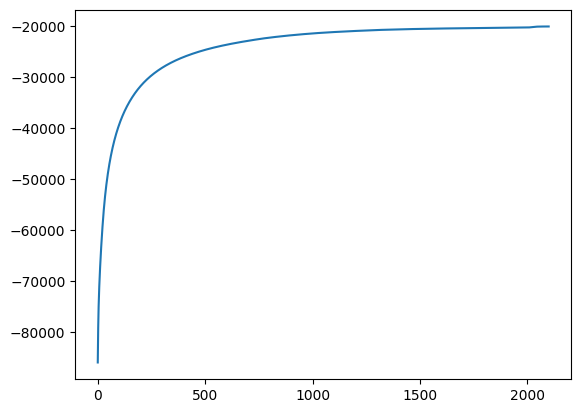

In [30]:
plt.plot(range(len(elbos)), elbos)

<BarContainer object of 2 artists>

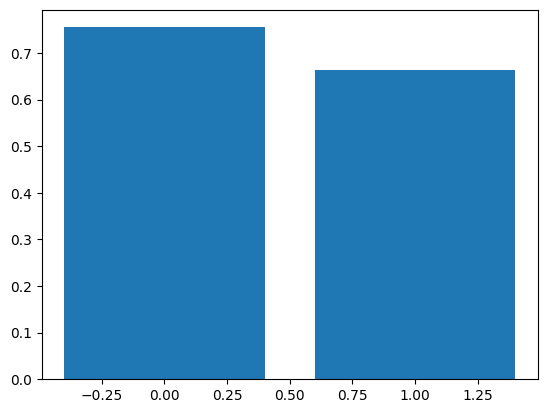

In [31]:
plt.bar(np.arange(latent_dim), bgplvm.kernel.lengthscales.numpy())

IndexError: index 3 is out of bounds for axis 1 with size 2

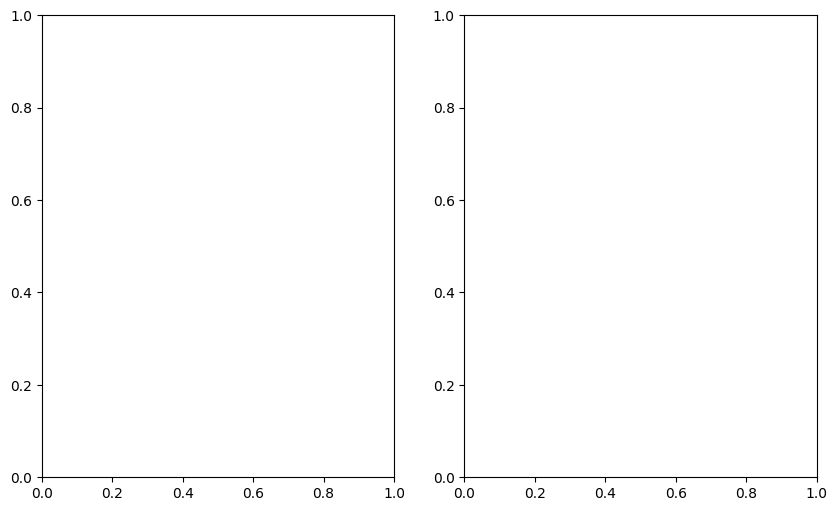

In [32]:
from matplotlib.patches import Ellipse

X_pca = ops.pca_reduce(Y, latent_dim).numpy()
bgplvm_X_mean = bgplvm.X_data_mean.numpy()
f, ax = plt.subplots(1, 2, figsize=(10, 6))

for i in np.unique(labels):
    ax[0].scatter(X_pca[labels == i, 3], X_pca[labels == i, 4], label=i)
    ax[1].scatter(gplvm_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=i)
    ax[0].set_title("PCA")
    ax[1].set_title("BGPLVM")

In [ ]:
str(i)[2:-1]


'8'

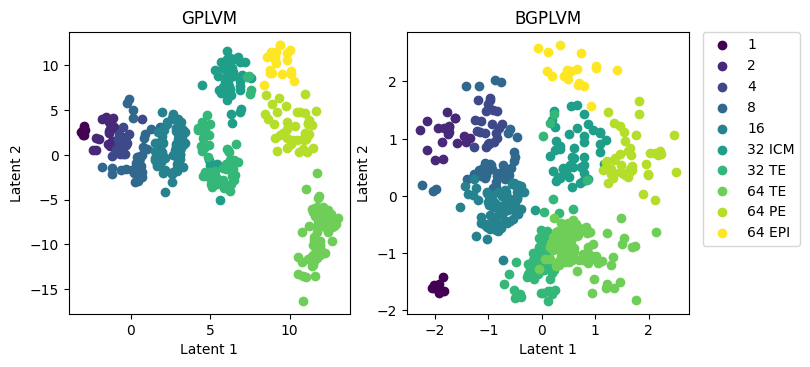

In [36]:
gplvm_X_mean = gplvm.data[0].numpy()
bgplvm_X_mean = bgplvm.X_data_mean.numpy()
f, ax = plt.subplots(1, 2, figsize=(8,4))
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
# colors = [mpl.colors.to_hex(plt.cm.viridis(i)) for i in np.linspace(0, 1, len(np.unique(labels)))]
unique_labels, idx = np.unique(labels, return_index=True)
unique_labels = labels.numpy()[np.sort(idx)]

for n, i in enumerate(unique_labels):
    ax[0].scatter(gplvm_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    ax[1].scatter(bgplvm_X_mean[labels == i, 0], bgplvm_X_mean[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    ax[0].set_title("GPLVM")
    ax[1].set_title("BGPLVM")

for ax_ in ax:
    ax_.set_box_aspect(1)   
    ax_.set_xlabel("Latent 1")
    ax_.set_ylabel("Latent 2")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig('GPLVM_BGPLVM_cell_data.png', dpi=500, bbox_inches='tight')

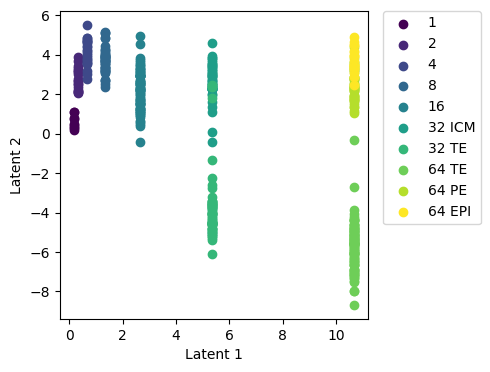

In [43]:
X_mean_init = X_mean_init.numpy()
# bgplvm_X_mean = gplvm.X_data_mean.numpy()
f, ax = plt.subplots(1, 1, figsize=(4,4))
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
# colors = [mpl.colors.to_hex(plt.cm.viridis(i)) for i in np.linspace(0, 1, len(np.unique(labels)))]
unique_labels, idx = np.unique(labels, return_index=True)
unique_labels = labels.numpy()[np.sort(idx)]

for n, i in enumerate(unique_labels):
    ax.scatter(X_mean_init[labels == i, 0], X_mean_init[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    # ax.set_title("GPLVM")


ax.set_box_aspect(1)   
ax.set_xlabel("Latent 1")
ax.set_ylabel("Latent 2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig('PCA_cell_data.png', dpi=500, bbox_inches='tight')

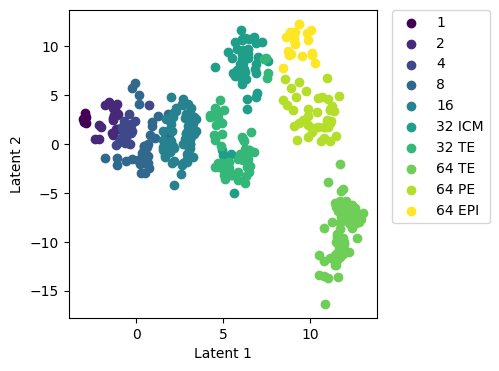

In [42]:
gplvm_X_mean = gplvm.data[0].numpy()
# bgplvm_X_mean = gplvm.X_data_mean.numpy()
f, ax = plt.subplots(1, 1, figsize=(4,4))
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
# colors = [mpl.colors.to_hex(plt.cm.viridis(i)) for i in np.linspace(0, 1, len(np.unique(labels)))]
unique_labels, idx = np.unique(labels, return_index=True)
unique_labels = labels.numpy()[np.sort(idx)]

for n, i in enumerate(unique_labels):
    ax.scatter(gplvm_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    # ax.set_title("GPLVM")


ax.set_box_aspect(1)   
ax.set_xlabel("Latent 1")
ax.set_ylabel("Latent 2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig('GPLVM_cell_data.png', dpi=500, bbox_inches='tight')

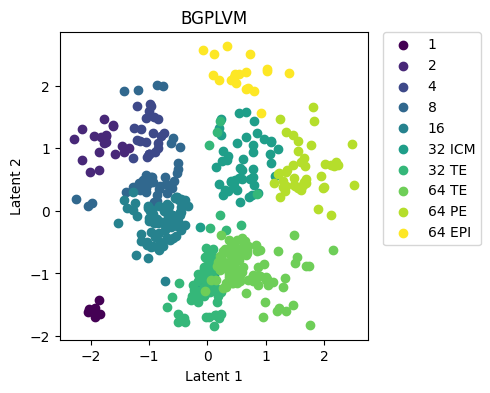

In [41]:
gplvm_X_mean = gplvm.data[0].numpy()
bgplvm_X_mean = bgplvm.X_data_mean.numpy()
f, ax = plt.subplots(1, 1, figsize=(4,4))
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
# colors = [mpl.colors.to_hex(plt.cm.viridis(i)) for i in np.linspace(0, 1, len(np.unique(labels)))]
unique_labels, idx = np.unique(labels, return_index=True)
unique_labels = labels.numpy()[np.sort(idx)]

for n, i in enumerate(unique_labels):
    ax.scatter(bgplvm_X_mean[labels == i, 0], bgplvm_X_mean[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    ax.set_title("BGPLVM")


ax.set_box_aspect(1)   
ax.set_xlabel("Latent 1")
ax.set_ylabel("Latent 2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig('BGPLVM_cell_data.png', dpi=500, bbox_inches='tight')

Text(0.5, 1.0, 'BGPLVM')

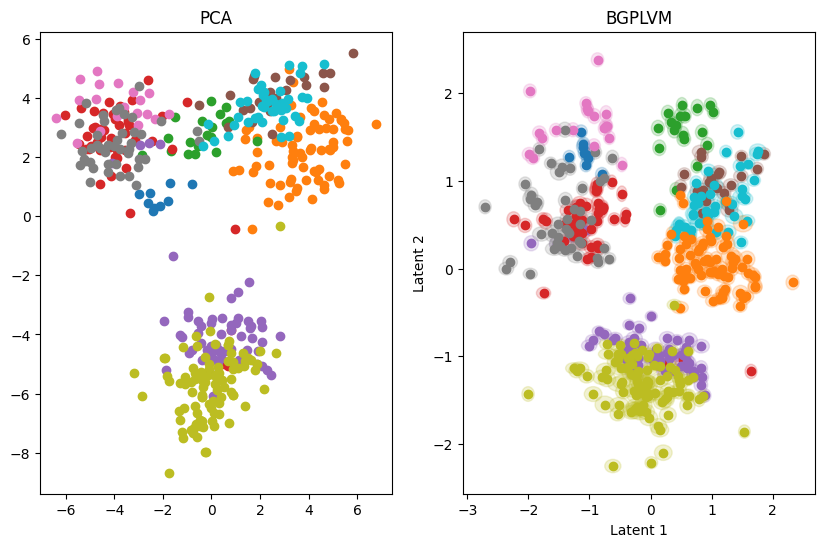

In [ ]:
from matplotlib.patches import Ellipse

X_pca = ops.pca_reduce(Y, latent_dim).numpy()
gplvm_X_mean = bgplvm.X_data_mean.numpy()
f, ax = plt.subplots(1, 2, figsize=(10, 6))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']*12
colors = {label: colors[i] for i, label in enumerate(np.unique(labels))}

H_mean = bgplvm.X_data_mean.numpy()
H_var = bgplvm.X_data_var.numpy()

for i in range(len(H_mean)):
    color = colors[labels.numpy()[i]]
    ax[1].scatter(H_mean[i, 3], H_mean[i, 4],
               color=color)
    # ax.annotate(f'{list(model.coregion_coords["PrimerPairReporter"].keys())[i]}', (h[dims[0]], h[dims[1]]), fontsize=10)
    ax[1].set_xlabel(f'Latent 1')
    ax[1].set_ylabel(f'Latent 2')
    # ax.set_title('LVM Latent Variable Coordinates')
    circle1 = Ellipse((H_mean[i, 3], H_mean[i, 4]), 1.95 * np.sqrt(H_var[i, 3]),
                      1.95 * np.sqrt(H_var[i, 4]), color=color, alpha=0.2, zorder=0)
    ax[1].add_patch(circle1)
for i in np.unique(labels):   
    ax[0].scatter(X_pca[labels == i, 3], X_pca[labels == i, 4], label=i)
ax[0].set_title("PCA")
ax[1].set_title("BGPLVM")



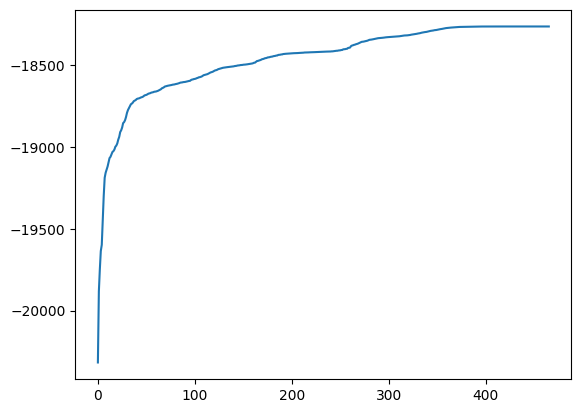

In [ ]:
plt.plot(range(len(lml)), lml)

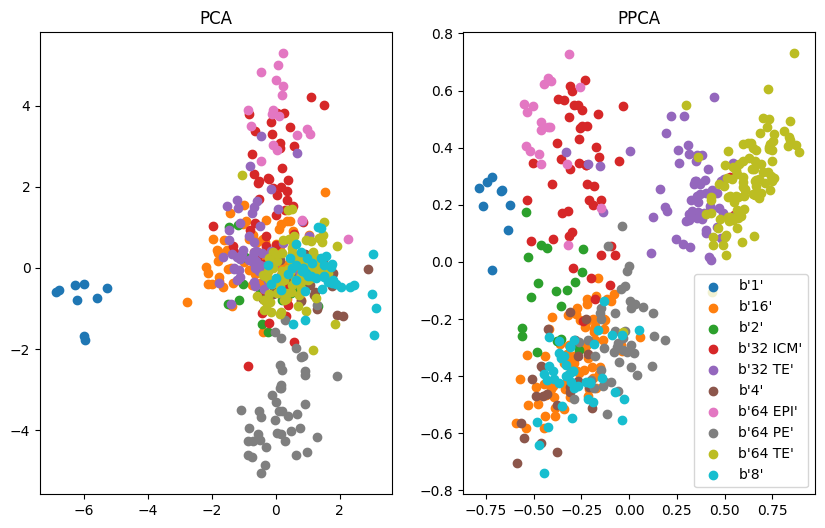

In [ ]:
X_pca = ops.pca_reduce(Y, latent_dim).numpy()
ppca_X_mean = ppca.data[0].numpy()
f, ax = plt.subplots(1, 2, figsize=(10, 6))

for i in np.unique(labels):
    ax[0].scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=i)
    ax[1].scatter(ppca_X_mean[labels == i, 0], ppca_X_mean[labels == i, 1], label=i)
    ax[0].set_title("PCA")
    ax[1].set_title("PPCA")
ax[1].legend()

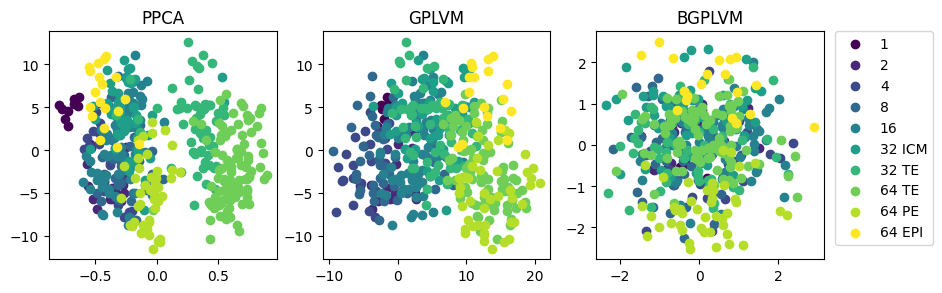

In [ ]:
gplvm_X_mean = gplvm.data[0].numpy()
bgplvm_X_mean = bgplvm.X_data_mean.numpy()
f, ax = plt.subplots(1, 3, figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
# colors = [mpl.colors.to_hex(plt.cm.viridis(i)) for i in np.linspace(0, 1, len(np.unique(labels)))]
unique_labels, idx = np.unique(labels, return_index=True)
unique_labels = labels.numpy()[np.sort(idx)]

for n, i in enumerate(unique_labels):
    ax[0].scatter(ppca_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    ax[1].scatter(gplvm_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    ax[2].scatter(bgplvm_X_mean[labels == i, 0], bgplvm_X_mean[labels == i, 1], label=str(i)[2:-1], color=colors[n])
    ax[0].set_title("PPCA")
    ax[1].set_title("GPLVM")
    ax[2].set_title("BGPLVM")

for ax_ in ax:
    ax_.set_box_aspect(1)   
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig('GPLVMs.png', dpi=500, bbox_inches='tight')